## Differential Equation Model Analysis

This notebook presents an analysis of a system of differential equations to model the local control of cellular proliferation during organ regeneration in zebrafish. The objective is to fit the model to observed data, estimate parameters and visualize the model predictions with uncertainties.

### Dataset
The dataset used in this analysis consists of Hair, Mantle and Sustentacular cells number as a function of time in days.

### Model

The model is a system of differential equations:

$
\frac{dH}{dt} = 2 \left(1 - p_{\text{SS}} - p_{\text{MM}} - p_{\text{SM}}\right) \frac{\nu S_{50}^{h} S}{S_{50}^{h} + S^{h}}
$

$
\frac{dM}{dt} = \left(2 p_{\text{MM}} + p_{\text{SM}}\right) \frac{\nu S_{50}^{h} S}{S_{50}^{h} + S^{h}} + \frac{2f\nu M_{50}^{h} M}{M_{50}^{h} + M^{h}}
$

$
\frac{dS}{dt} = \left(3 p_{\text{SS}} + 2 p_{\text{SM}} - 1\right) \frac{\nu S_{50}^{h} S}{S_{50}^{h} + S^{h}}
$

### Methodology
The analysis includes parameter estimation using Approximate Bayesian Computation (ABC), followed by visualization of parameter distributions and model predictions against observed data.

In [1]:
# Libraries
import pandas as pd
import pyabc
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from pyabc.visualization import plot_kde_matrix, plot_acceptance_rates_trajectory, plot_epsilons, plot_credible_intervals
import seaborn as sns

In [2]:
# Measured data
df = pd.read_csv("data.csv", index_col='time')
t_measured = np.asarray(df.index)
H_measured = np.asarray(df["H_mean"])
M_measured = np.asarray(df["M_mean"])
S_measured = np.asarray(df["S_mean"])
H_error = np.asarray(df["H_std"])
M_error = np.asarray(df["M_std"])
S_error = np.asarray(df["S_std"])

data = {"H_mean":  H_measured, "M_mean":  M_measured, "S_mean":  S_measured}

In [3]:
# System of differential equations model impleplementation
def model(parameters):
    # Extract parameters
    v, S50, M50, h = parameters['v'], parameters['S50'], parameters['M50'], parameters['h']

    # Constants
    Phh = 0.16
    Pmm = 0.03
    Psm = 0.03
    Pss = 0.78
    f = 1.5

    # Differential equations
    def diff_eqs(y, t):
        H, M, S = y
        f0 = 2 * (1 - Pss - Pmm - Psm) * ((v * (S50**h) * S) / (S50**h + S**h))
        f1 = (2 * Pmm + Psm) * ((v * (S50**h) * S) / (S50**h + S**h)) + (f * v * (M50**h) * M) / (M50**h + M**h)
        f2 = (Pss - Pmm - Phh) * ((v * (S50**h) * S) / (S50**h + S**h))
        return [f0, f1, f2]

    # Initial conditions and time points
    y0 = [0, 2, 4]
    t = np.linspace(0, max(t_measured), len(t_measured))

    # Solve the differential equations
    sol = odeint(diff_eqs, y0, t)

    # Convert the solution to a dictionary format
    solution_dict = {
        'H_sim': sol[:, 0],
        'M_sim': sol[:, 1],
        'S_sim': sol[:, 2]
    }

    return solution_dict

In [4]:
# Distance function
def distance(simulation, data):
    
    # Calculate the Euclidean distance for each variable
    h_distance = np.sqrt(np.sum((simulation['H_sim'] - data['H_mean']) ** 2))
    m_distance = np.sqrt(np.sum((simulation['M_sim'] - data['M_mean']) ** 2))
    s_distance = np.sqrt(np.sum((simulation['S_sim'] - data['S_mean']) ** 2))

    # Combine the distances
    total_distance = h_distance + m_distance + s_distance

    return total_distance

In [5]:
# Define prior distributions for the unknown parameters
prior = pyabc.Distribution(v=pyabc.RV("uniform", 0, 10),
                           S50=pyabc.RV("uniform", 0, 100),
                           M50=pyabc.RV("uniform", 0, 100),
                           h=pyabc.RV("uniform", 0, 100))

In [6]:
# Set up and run the ABC analysis
abc = pyabc.ABCSMC(
    model, prior, distance, population_size=50
)
history = abc.new("sqlite:///pyabc_output.db", data)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30)

ABC.Sampler INFO: Parallelize sampling on 12 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2024-01-16 21:43:32>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.87900396e+02.
ABC INFO: Accepted: 50 / 104 = 4.8077e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 2.12254010e+02.
ABC INFO: Accepted: 50 / 140 = 3.5714e-01, ESS: 3.1143e+01.
ABC INFO: t: 2, eps: 1.25382587e+02.
ABC INFO: Accepted: 50 / 121 = 4.1322e-01, ESS: 3.0834e+00.
ABC INFO: t: 3, eps: 6.95763221e+01.
ABC INFO: Accepted: 50 / 127 = 3.9370e-01, ESS: 2.1607e+01.
ABC INFO: t: 4, eps: 5.75065498e+01.
ABC INFO: Accepted: 50 / 107 = 4.6729e-01, ESS: 2.8896e+01.
ABC INFO: t: 5, eps: 4.86208669e+01.
ABC INFO: Accepted: 50 / 118 = 4.2373e-01, ESS: 4.2185e+01.
ABC INFO: t: 6, eps: 4.10542524e+01.
ABC INFO: Accepted: 50 / 116 = 4.3103e-01, ESS: 4.0869e+01.
ABC INFO: t: 7, eps: 3.70289600e+01.
ABC INFO: Accepted: 50 / 127 = 3.9370e-01, ESS: 1.9837e+01.
ABC INFO: t: 8, eps: 3.37088249e+01.
ABC INFO: Accepted: 50 /

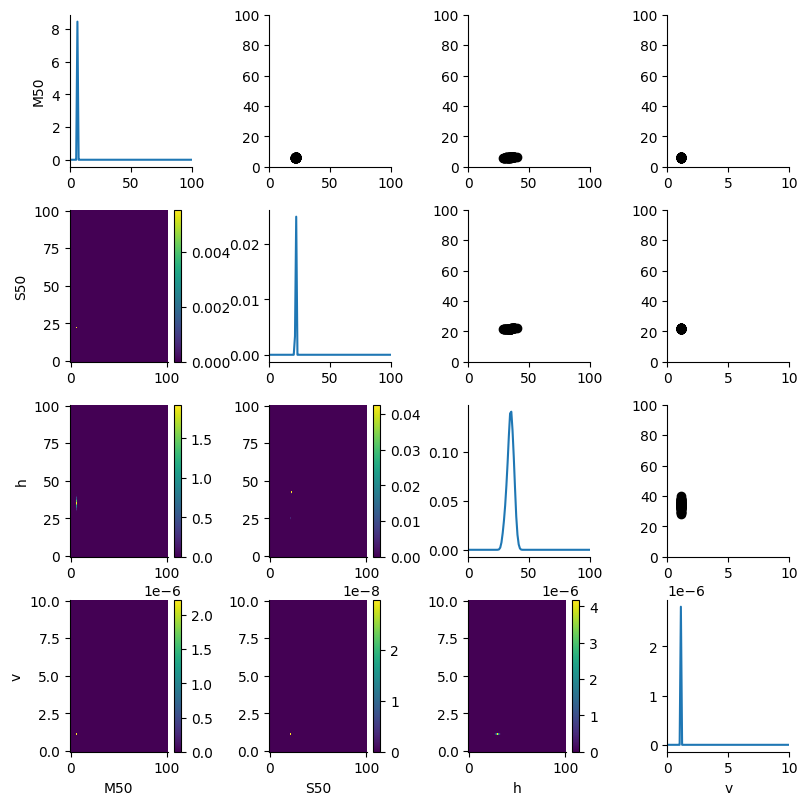

<Figure size 640x480 with 0 Axes>

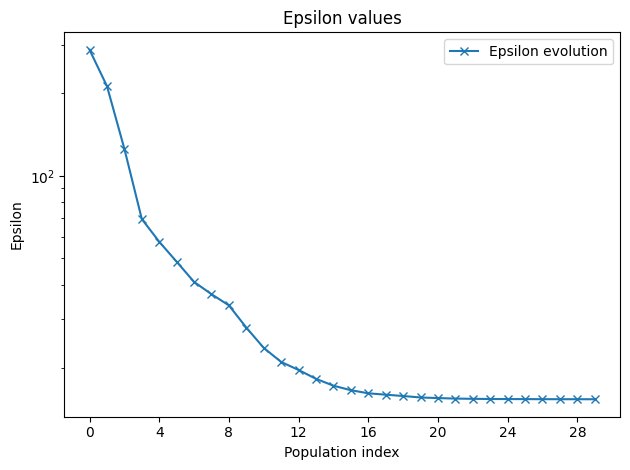

In [7]:
# Parameter distribution visualization
dfw = history.get_distribution(m=0)
grid = plot_kde_matrix(*dfw,
                limits={"M50": (0, 100),
                        "S50": (0, 100),
                        "h":   (0, 100),
                        "v":   (0, 10)}, numx=100, numy=100)
plt.gcf().set_size_inches(8, 8)
filename = "./" + "fitA.png"    
plt.savefig(filename, dpi=300)  

# Convergence
fig = plt.figure()
filename = "./" + "fitB.png"  
plot_epsilons(history,["Epsilon evolution"]).get_figure().savefig(filename, dpi=300) 

In [8]:
# Best parameters values
df = dfw[0]
M50_mean, M50_dt = round(df["M50"].mean(),2), round(df["M50"].std(),2)
print("M50: ", M50_mean, "+-", M50_dt)
S50_mean, S50_dt = round(df["S50"].mean(),2), round(df["S50"].std(),2)
print("S50: ", S50_mean, "+-", S50_dt)
h_mean, h_dt = round(df["h"].mean(),2), round(df["h"].std(),2)
print("h: ", h_mean, "+-", h_dt)
v_mean, v_dt = round(df["v"].mean(),2), round(df["v"].std(),2)
print("v: ", v_mean, "+-", v_dt)

M50:  6.04 +- 0.04
S50:  21.77 +- 0.15
h:  34.18 +- 2.65
v:  1.12 +- 0.0


In [9]:
# Generate multiple sets of predictions
def model(y, t, M50, S50, h, v):
    H, M, S = y
    # Constants
    Phh = 0.16
    Pmm = 0.03
    Psm = 0.03
    Pss = 0.78
    f = 1.5
    # Use the mean values of your parameters
    f0 = 2 * (1 - Pss - Pmm - Psm) * ((v * (S50**h) * S) / (S50**h + S**h))
    f1 = (2 * Pmm + Psm) * ((v * (S50**h) * S) / (S50**h + S**h)) + (f * v * (M50**h) * M) / (M50**h + M**h)
    f2 = (Pss - Pmm - Phh) * ((v * (S50**h) * S) / (S50**h + S**h))
    return [f0, f1, f2]

# Set up initial conditions and time points
y0 = [0, 2, 4]
t = np.linspace(0, max(t_measured), len(t_measured))

# Number of simulations
num_simulations = 100

# Storage for simulations
simulations = []

# Sample parameters from normal distributions based on mean and std
for _ in range(num_simulations):
    sampled_M50 = np.random.normal(M50_mean, M50_dt)
    sampled_S50 = np.random.normal(S50_mean, S50_dt)
    sampled_h = np.random.normal(h_mean, h_dt)
    sampled_v = np.random.normal(v_mean, v_dt)

    # Solve the differential equations with sampled parameters
    solution = odeint(model, y0, t, args=(sampled_M50, sampled_S50, sampled_h, sampled_v))
    simulations.append(solution)

# Convert to NumPy array for easier manipulation
simulations = np.array(simulations)

# Calculate mean and standard deviation of simulations
mean_simulation = np.mean(simulations, axis=0)
std_simulation = np.std(simulations, axis=0)

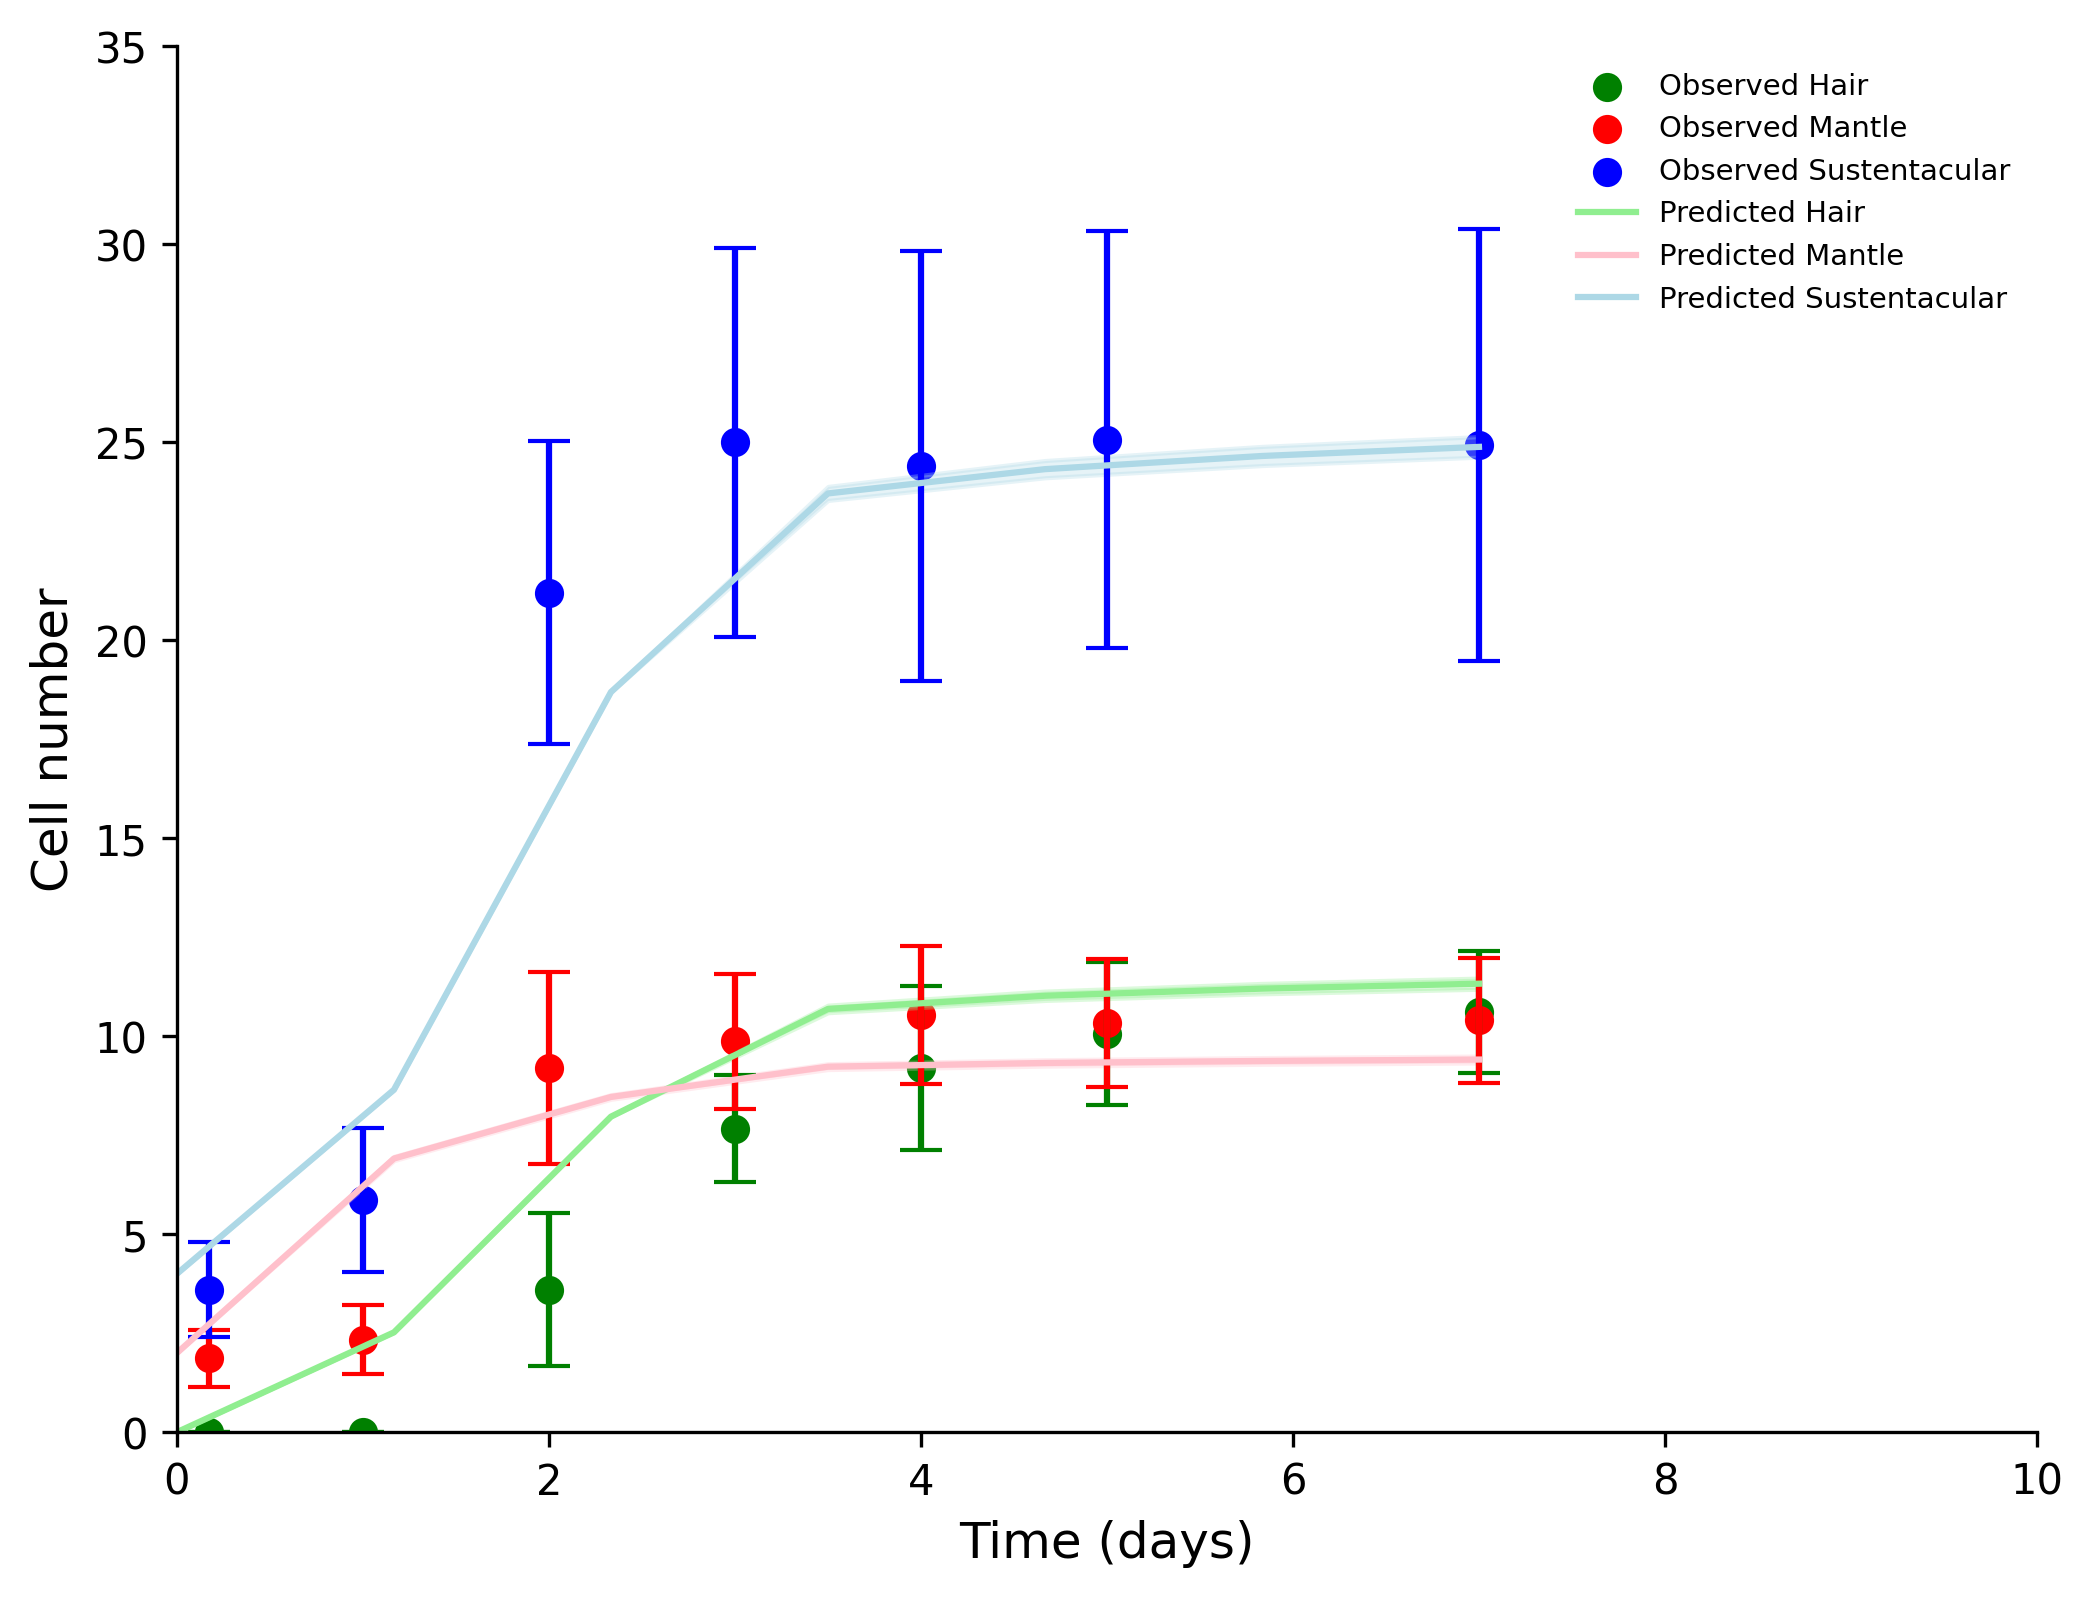

In [10]:
# Plotting
plt.figure(figsize=(8, 6), dpi=300)

# Plot observed data
plt.scatter(t_measured, H_measured, label='Observed Hair', color='green')
plt.scatter(t_measured, M_measured, label='Observed Mantle', color='red')
plt.scatter(t_measured, S_measured, label='Observed Sustentacular', color='blue')

# Plot observed data error
plt.errorbar(t_measured, H_measured, yerr=H_error, fmt='none', capsize=5, marker="o", color='green')
plt.errorbar(t_measured, M_measured, yerr=M_error, fmt='none', capsize=5, marker="o", color='red')
plt.errorbar(t_measured, S_measured, yerr=S_error, fmt='none', capsize=5, marker="o", color='blue')

# Plot mean predictions
plt.plot(t, mean_simulation[:, 0], label='Predicted Hair', color='lightgreen')
plt.plot(t, mean_simulation[:, 1], label='Predicted Mantle', color='pink')
plt.plot(t, mean_simulation[:, 2], label='Predicted Sustentacular', color='lightblue')

# Plot uncertainty (standard deviation)
plt.fill_between(t, mean_simulation[:, 0] - std_simulation[:, 0], mean_simulation[:, 0] + std_simulation[:, 0], color='lightgreen', alpha=0.3)
plt.fill_between(t, mean_simulation[:, 1] - std_simulation[:, 1], mean_simulation[:, 1] + std_simulation[:, 1], color='pink', alpha=0.3)
plt.fill_between(t, mean_simulation[:, 2] - std_simulation[:, 2], mean_simulation[:, 2] + std_simulation[:, 2], color='lightblue', alpha=0.3)

# Format
plt.xlim([0, 10])
plt.ylim([0, 35])
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Cell number", fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=7)
plt.savefig("cell_number.png", format='png', bbox_inches='tight')
plt.show()

In [11]:
# Calculate rates
f = 1.5
M50=  6.04
S50=  21.76
h=  34.55
v=  1.12
M = np.linspace(0,30,100)
S = np.linspace(0,30,100)
vs = v*S50**(h-1) / (S50**h+S**h)
vm = f*v*M50**(h-1) / (M50**h+M**h)

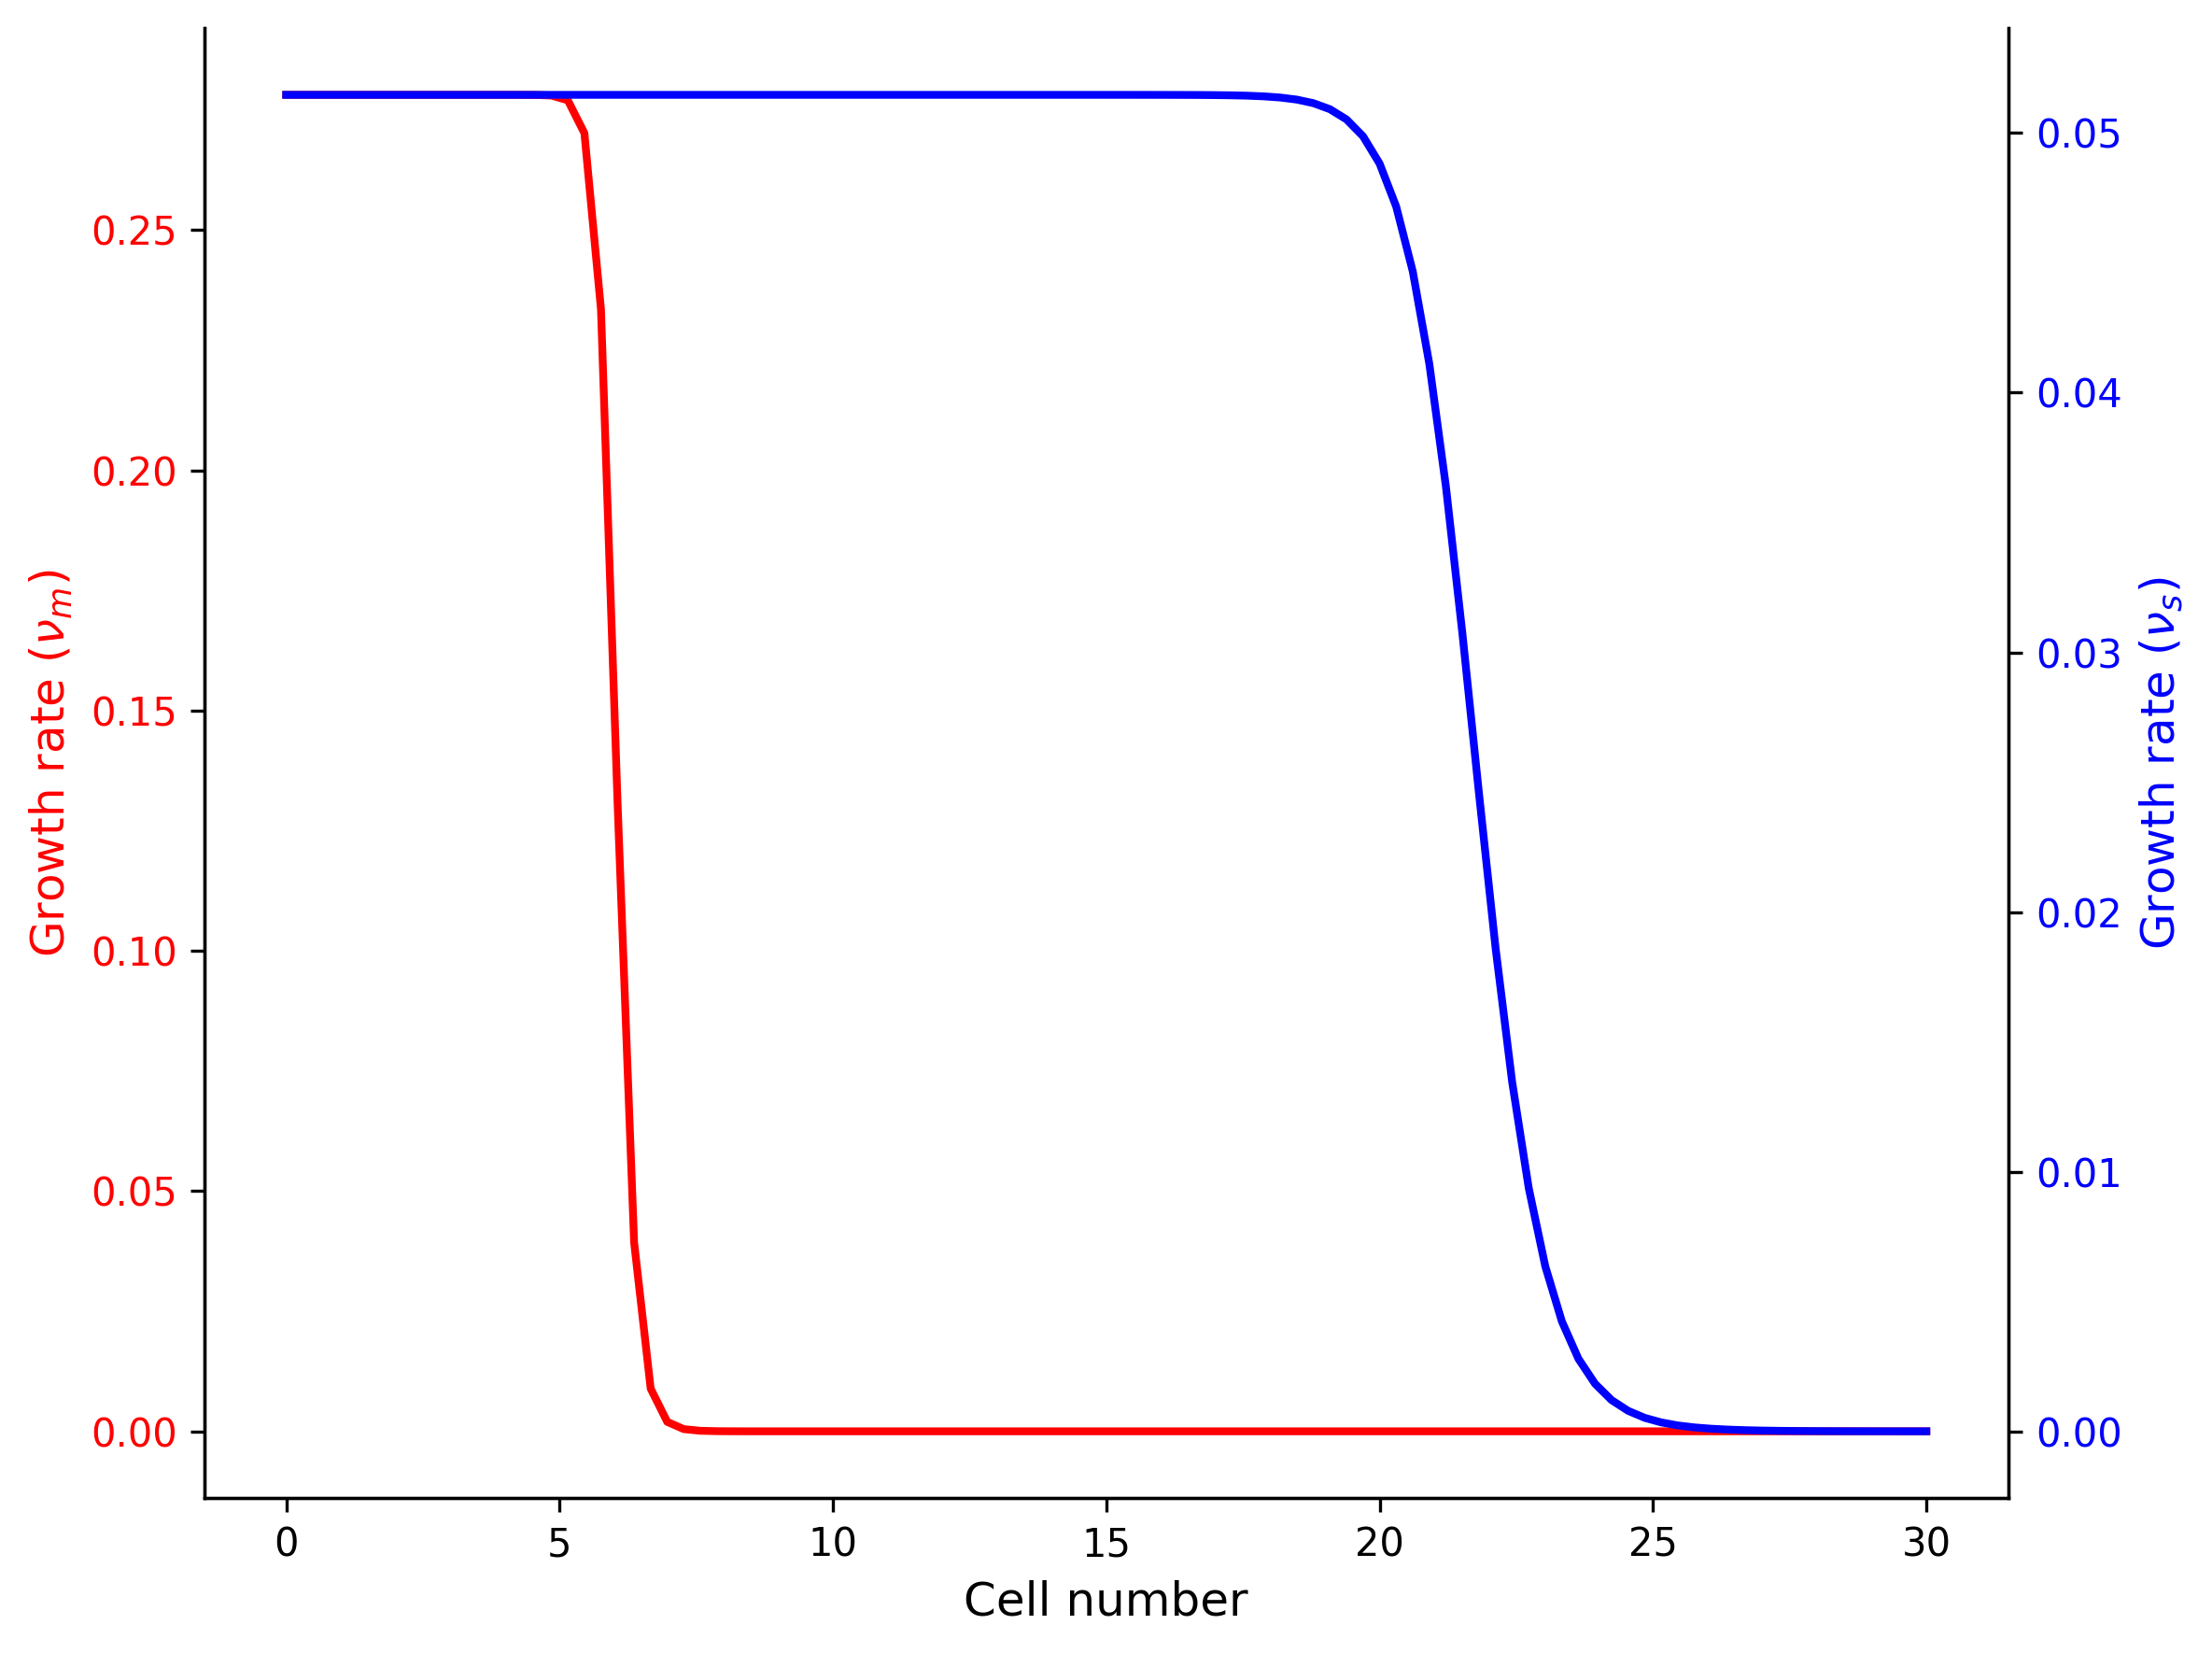

In [12]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=300)

# First plot (M vs vm) with left y-axis
ax1.plot(M, vm, '-', linewidth=2, color="red", label=r'$\nu_m$')
ax1.set_xlabel('Cell number', fontsize=12)
ax1.set_ylabel(r'Growth rate ($\nu_m$)', fontsize=12, color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.spines['top'].set_visible(False)

# Create a second y-axis for the second plot
ax2 = ax1.twinx()
ax2.plot(S, vs, '-', linewidth=2, color="blue", label=r'$\nu_s$')
ax2.set_ylabel(r'Growth rate ($\nu_s$)', fontsize=12, color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.spines['top'].set_visible(False)

# Save and show the plot
fig.tight_layout()  # Adjust layout
plt.savefig("rates.png", format='png', bbox_inches='tight')
plt.show()